# Mario: Basic Tasks

 **Goal:** Mario pick-up ladder, go to princess(goal) and avoid Bowser(obstacle) in 6x6 grid


Tasks:
1. Environment definition
2. State and Reward function
3. Q-learning update rule and policy (epsilon greedy and softmax)
4. Run and measure performance for multiple episodes, parameters

* observation_space = state space as the grid is a fully observable environment

In [1]:
#pip install gym==0.26.2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gym
from gym import Env, logger, spaces, utils
import random
from enum import Enum
import pandas as pd

In [3]:
print(gym.__version__)

0.25.2


In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Environment

In [5]:
# The Warehouse is divided into a grid. Use these 'tiles' to represent the objects on the grid.
class GridTile(Enum):
    _Floor = 0
    Mario = 1
    Ladder = 2
    Weapon = 3
    Dragon = 4
    Princess = 5
    Dragon2 = 6

    # Return the first letter of tile nme
    def __str__(self):
        return self.name[:1]

In [6]:
class gridEnv(gym.Env):
    def __init__(self, gridsize=(6, 6),
                 princess_position=(5,5),
                 dragon_position=(5,3),
                 dragon2_position=(4,3),
                 weapon_position=(4,5),
                 ladder_position=(3,3)):

        super(gridEnv, self).__init__()

        # Grid size 6x6
        self.gridsize = gridsize

        # Position of goal: Princess Peach
        self.princess_position = princess_position

        # Position of obstacle: dragon
        self.dragon_position = dragon_position

        # Position of obstacle: dragon 2
        self.dragon2_position = dragon2_position

        # Position of weapon
        self.weapon_position = weapon_position

        # Position of tool: Ladder
        self.ladder_position = ladder_position

        # Define action space: up, down, left, right
        self.action_space = spaces.Discrete(4)

        # Define observation space (state space): 0...5 rows/columns
        # Each position of the agent in the grid is a state
        self.observation_space = spaces.Box(low=0, high=max(self.gridsize), shape=(2,))

        # Define state where agent starts
        self.state = np.array([0, 0])

        # Initialise 6x6 grid where positions will be stored
        self.grid = np.zeros(self.gridsize)

        # Define ladder check
        self.ladder_pickup = False

        # Define weapon check
        self.weapon_pickup = False

        # Define if terminal state reached = learning episode ended
        self.done = False
        self.seed()

    def seed(self, seed=None):
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        if seed is not None:
            self.seed(seed)

        # Reset the Mario's position and the grid
        self.state = np.array([0, 0])
        self.done = False

        # Reset the grid (zeros) and place the goal position
        self.grid = np.zeros(self.gridsize)
        # Store positions
        self.grid[self.princess_position[0], self.princess_position[1]] = 2
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.ladder_position[1]] = 4
        self.grid[self.weapon_position[0], self.weapon_position[1]] = 5
        self.grid[self.dragon2_position[0], self.dragon2_position[1]] = 6

        self.ladder_pickup = False
        self.weapon_pickup = False

        return self.state


    def step(self, action):
        # Vi
        # Track old state
        old_state = self.state.copy()

        # Sultana
        # Move the agent based on the action: up, down, left, right
        if action == 0:  # Move up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 1:  # Move down
            self.state[0] = min(self.gridsize[0] - 1, self.state[0] + 1)
        elif action == 2:  # Move left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 3:  # Move right
            self.state[1] = min(self.gridsize[1] - 1, self.state[1] + 1)

        # Compute reward and check if episode ends
        reward, done = self.compute_reward(old_state)

        return self.state, reward, done


    def compute_reward(self, old_state):
        # Default penalty for each step taken
        reward = -1;
        self.done = False

        # Check if the agent reached the goal
        if np.array_equal(self.state, self.princess_position):
          if self.ladder_pickup == True:
            reward = 30
            self.done = True
          else:
            reward = 5
            self.done = True

        # Reward for picking up ladder
        elif np.array_equal(self.state, self.ladder_position):
          if self.ladder_pickup == False:
            reward = 10
            self.ladder_pickup = True

        # Reward for picking up weapon
        elif np.array_equal(self.state, self.weapon_position):
          if self.weapon_pickup == False:
            reward = 5
            self.weapon_pickup = True

        # Penalty for facing dragon 1 (with/without weapon)
        elif np.array_equal(self.state, self.dragon_position):
          if self.weapon_pickup == True:
            reward = -5
          else:
            reward = -30

        # Penalty for facing dragon 2 (with/without weapon)
        elif np.array_equal(self.state, self.dragon2_position):
          if self.weapon_pickup == True:
            reward = -5
          else:
            reward = -30

        # Vi
        # Penalty if the move was invalid (hit the wall)
        elif np.array_equal(self.state, old_state):
            reward = -10

        return reward, self.done


    # def render(self, mode='human'):
    #     # Clear the grid and update it with the agent's current position
    #     self.grid = np.zeros(self.gridsize)
    #     # Mario
    #     self.grid[self.state[0], self.state[1]] = 1
    #     # Princess Peach
    #     self.grid[self.princess_position[0], self.princess_position[1]] = 2

    #     # Dragon 1,2
    #     self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
    #     self.grid[self.ladder_position[0], self.ladder_position[1]] = 4

    #     # Plot the grid
    #     plt.imshow(self.grid, cmap='Blues', interpolation='nearest')
    #     #plt.xticks([])
    #     #plt.yticks([])
    #     plt.show()


    def render_2(self, mode='human'):
        # Print current state on console
        for r in range(self.gridsize[0]):
            for c in range(self.gridsize[1]):
                if ([r, c] == [self.state[0], self.state[1]]):
                    print(GridTile.Mario, end=' ')
                elif ([r,c] == [self.ladder_position[0],self.ladder_position[1]]):
                    print(GridTile.Ladder, end=' ')
                elif ([r,c] == [self.weapon_position[0],self.weapon_position[1]]):
                    print(GridTile.Weapon, end=' ')
                elif ([r,c] == [self.dragon_position[0], self.dragon_position[1]]):
                    print(GridTile.Dragon, end=' ')
                elif ([r,c] == [self.dragon2_position[0], self.dragon2_position[1]]):
                    print(GridTile.Dragon2, end=' ')
                elif ([r,c] == [self.princess_position[0], self.princess_position[1]]):
                    print(GridTile.Princess, end=' ')
                else:
                    print(GridTile._Floor, end=' ')

            print()
        print()


## 1. Experiment with ϵ-greedy

### Q-learning and ϵ-greedy policy

In [7]:
def greedy_policy(q_table, state):
  action = np.argmax(q_table[state])
  return action


def epsilon_greedy_policy(q_table, state, epsilon, grid_width):
    flat_state = int(state[0]) * grid_width + int(state[1])  # Ensure integer index
    random_int = random.uniform(0, 1)
    if random_int < epsilon:
        #action = env.action_space.sample()
        action = np.random.choice(env.action_space.n)
    else:
        action = np.argmax(q_table[flat_state])
    return action


In [8]:
def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning function
def q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps):

    # Initialize Q-table with shape (36, 4) = (state, action)
    q_table = np.zeros((env.gridsize[0] * env.gridsize[1], env.action_space.n))

    total_reward = 0
    # Vi
    # Create a df to store episode and number of steps
    df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])

    for episode in range(episodes):
        #epsilon = min_epsilon + (epsilon- min_epsilon)*np.exp(-epsilon_decay*episodes)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)


        state = env.reset()

        # Convert state to index
        state_index = state_to_index(state, env.gridsize[1])

        #print(state)
        done = False

        # Vi
        num_step = 0
        reward_per_episode = 0
        print("--- Episode",episode,"---")

        while not done and num_step <max_steps:

            # Choose action based on epsilon-greedy strategy
            action = epsilon_greedy_policy(q_table, state, epsilon, env.gridsize[1])

            # Take the action and observe the result
            next_state, reward, done = env.step(action)

            # Convert next state to index
            next_state_index = state_to_index(next_state, env.gridsize[1])

            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            # Move to the next state
            state = next_state
            # Update the state index
            state_index = next_state_index
            #env.render_2()

            # Add up reward
            total_reward +=reward

            # Track number of steps
            num_step = num_step+1
            # Track reward per episode

            reward_per_episode += reward


        #epsilon = max(min_epsilon, epsilon * epsilon_decay)
        new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
        df_epsisode.loc[len(df_epsisode)] = new_track
        print("--reward:", reward)
        print ('***epsilon:', epsilon)

        # Decay epsilon to reduce exploration over time



    return q_table, total_reward, df_epsisode

### Run Q-learning

#### Test Environment

In [9]:
# Hyperparameters of Q-learning
alpha=0.5
gamma=0.9
epsilon = 1.0
epsilon_decay=0.999
min_epsilon = 0.05
episodes=1500
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_steps_1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.999
--- Episode 1 ---
--reward: 30
***epsilon: 0.998001
--- Episode 2 ---
--reward: 30
***epsilon: 0.997002999
--- Episode 3 ---
--reward: 30
***epsilon: 0.996005996001
--- Episode 4 ---
--reward: 30
***epsilon: 0.995009990004999
--- Episode 5 ---
--reward: 30
***epsilon: 0.994014980014994
--- Episode 6 ---
--reward: 30
***epsilon: 0.993020965034979
--- Episode 7 ---
--reward: 30
***epsilon: 0.9920279440699441
--- Episode 8 ---
--reward: -1
***epsilon: 0.9910359161258742
--- Episode 9 ---
--reward: 30
***epsilon: 0.9900448802097482
--- Episode 10 ---
--reward: 30
***epsilon: 0.9890548353295385
--- Episode 11 ---
--reward: 30
***epsilon: 0.988065780494209
--- Episode 12 ---
--reward: 30
***epsilon: 0.9870777147137147
--- Episode 13 ---
--reward: 30
***epsilon: 0.986090636999001
--- Episode 14 ---
--reward: 30
***epsilon: 0.9851045463620021
--- Episode 15 ---
--reward: 30
***epsilon: 0.98411944181564
--- Episode 16 ---
--reward: 30
***epsilon:

In [10]:
# Q-values dataframe for 36 states (6x6 grid position) and 4 actions (up, down, left, right)
Q_values=pd.DataFrame(q_table, columns=['up', 'down', 'left', 'right'])
Q_values

up       down       left      right
0    1.952229  13.107746   1.982707  11.826353
1    2.200269  13.913873   9.796426  15.008706
2    5.289753  18.840682  10.745098  12.654727
3    2.242102  17.596095  11.224995   9.838228
4   -0.275678  10.278892  11.248737  10.149423
5    2.881554  12.852473   8.768980   2.509359
6   10.321036  11.132272   3.654470  15.577658
7   10.319825  18.708021  13.179732  15.528567
8   15.812701  21.599792  15.279325  16.155702
9   16.558643  18.124830  17.817411  14.913653
10  10.136123  12.808253  16.418931  14.332744
11   9.527713  20.088396  14.884639   6.579881
12  10.247047  10.568435   6.544694  15.357023
13  15.974594  18.849081  11.040530  22.176645
14  18.245234  26.822212  18.410364  18.087996
15  17.559744  23.524406  18.129765  18.231690
16  13.580371  23.617155  19.016834  14.434308
17  15.571844  26.786451  18.126985  10.780398
18  11.355667  10.596306   5.672075  11.406573
19  15.853669  12.354840  12.701381  20.776526
20  22.529769  21.991192  19.000014  27.485014
21  21.192444 -10.525504  23.702208  23.980844
22  18.766619  21.112481  20.222480  27.792090
23  21.359936  31.999268  23.368458  18.255758
24  12.190725   9.040293   1.111337  14.501269
25  13.396144  11.737330  11.629458  12.715343
26  25.433282  13.053586  13.297618  -6.940953
27  20.395315  -8.748193  16.893251  20.513097
28  22.047758  21.167151   7.730124  27.482111
29  27.217758  30.000000  23.180065  25.227837
30  10.470944   0.379863   0.526302  12.104017
31  14.927826   2.535915   9.247190  10.728352
32  18.357221   3.934953  10.303834  -6.827868
33  -4.872800   9.813399  15.406731  25.799475
34  22.524290  16.233269  -6.817893  28.437500
35   0.000000   0.000000   0.000000   0.000000

In [11]:
df_episode_steps_1['Reward'][50:60]

50     -47
51    -144
52    -143
53    -292
54      -2
55     -58
56     -64
57   -1171
58    -115
59    -798
Name: Reward, dtype: int64

In [12]:
# Convert Rewards/episode to series
rewards_series=pd.Series(df_episode_steps_1['Reward'].values, name="Reward")

steps_series=pd.Series(df_episode_steps_1['Num_steps'].values, name="Step")

rewards_series[0:6]

0   -189
1   -503
2   -434
3   -257
4   -462
5   -842
Name: Reward, dtype: int64

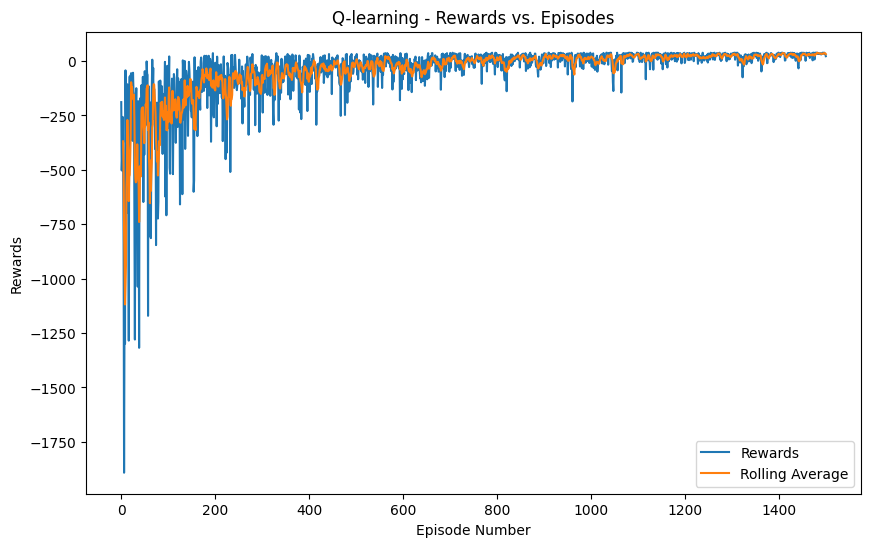

In [13]:
#### Plot of Rewards and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning - Rewards vs. Episodes")

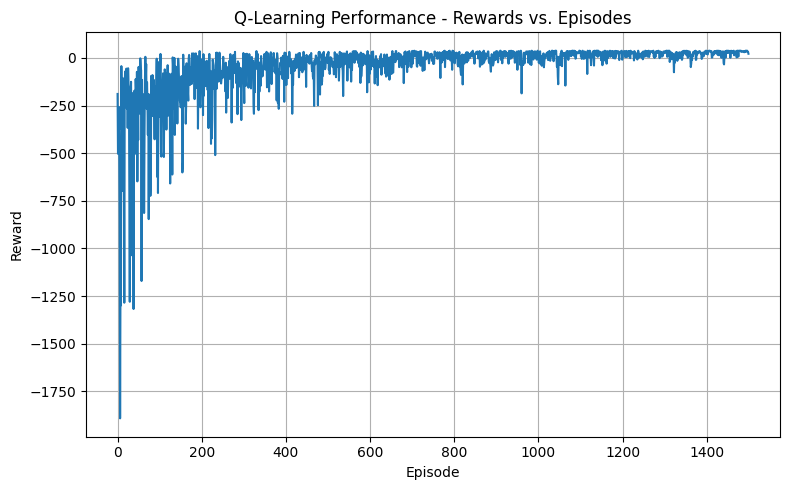

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps_1['Episode'], rewards_series)
plt.title('Q-Learning Performance - Rewards vs. Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.tight_layout()
plt.show()

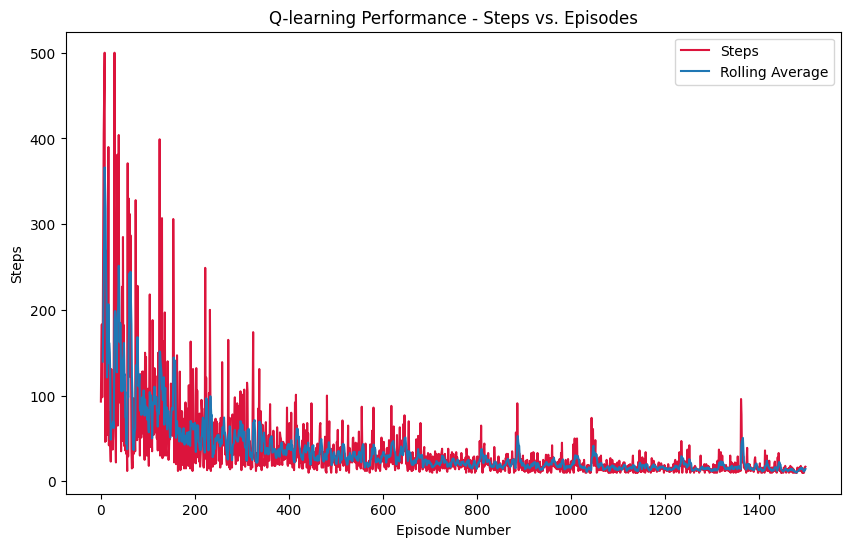

In [15]:
#### Plot of Steps and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

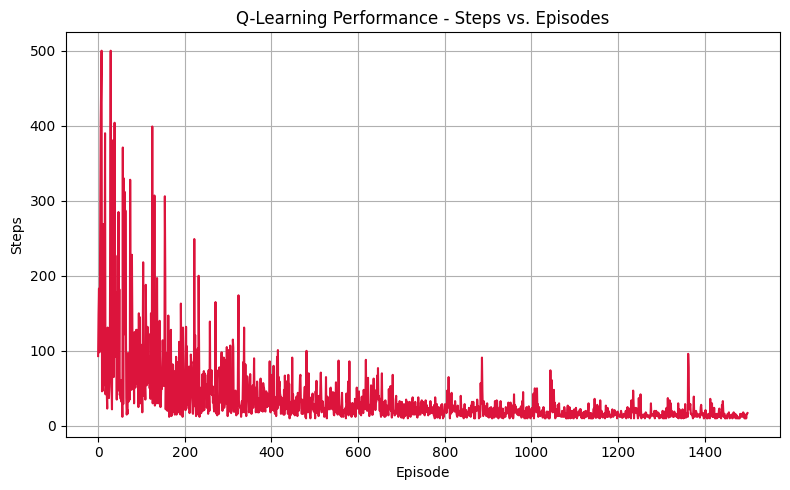

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps_1['Episode'], steps_series, color='crimson')
plt.title('Q-Learning Performance - Steps vs. Episodes')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Random Search: Best Parameters - Tuning

In [17]:
import random
min_epsilon=0.05
max_steps=300

def random_search_q_learning(env, param_grid, num_samples=60):
    # Store the best parameters and performance
    best_params = None
    best_performance = float('-inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(num_samples):
        # Randomly sample values for each hyperparameter
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        epsilon_decay = random.choice(param_grid['epsilon_decay'])
        episodes = random.choice(param_grid['episodes'])

        # Initialize total reward tracker
        total_reward = 0

        # Call Q-learning function with the current set of hyperparameters
        #print(f"Running random search with: alpha={alpha}, gamma={gamma}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, episodes={episodes}")
        q_table, total_reward, df_episode = q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon,max_steps, episodes)

        average_rewards = np.mean(df_episode['Reward'].values[-500:])

        # Record the best performance
        if average_rewards > best_performance:
            best_performance = average_rewards
            best_params = {'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay, 'episodes': episodes}

    return best_params, best_performance

# Define the hyperparameter grid (ranges for each hyperparameter)
param_grid = {
    'alpha': [0.1, 0.4, 0.7, 0.9],  # Learning rate
    'gamma': [0.4, 0.8, 0.9, 0.99],  # Discount factor
    'epsilon': [0.1,  0.5, 0.9, 1.0],  # Initial epsilon
    'epsilon_decay': [0.9, 0.99, 0.999, 0.9999],  # Decay factor for epsilon
    'episodes': [500, 1000, 1500],  # Number of episodes to run
}


# Perform random search
best_params, best_performance = random_search_q_learning(env, param_grid, num_samples=60)

# Output the results
print(f"Best parameters: {best_params}")
print(f"Best performance: {best_performance}")

Streaming output truncated to the last 5000 lines.
--- Episode 134 ---
--reward: 30
***epsilon: 0.05
--- Episode 135 ---
--reward: 30
***epsilon: 0.05
--- Episode 136 ---
--reward: 30
***epsilon: 0.05
--- Episode 137 ---
--reward: 30
***epsilon: 0.05
--- Episode 138 ---
--reward: 30
***epsilon: 0.05
--- Episode 139 ---
--reward: 30
***epsilon: 0.05
--- Episode 140 ---
--reward: 30
***epsilon: 0.05
--- Episode 141 ---
--reward: 30
***epsilon: 0.05
--- Episode 142 ---
--reward: 30
***epsilon: 0.05
--- Episode 143 ---
--reward: 30
***epsilon: 0.05
--- Episode 144 ---
--reward: 30
***epsilon: 0.05
--- Episode 145 ---
--reward: 30
***epsilon: 0.05
--- Episode 146 ---
--reward: 30
***epsilon: 0.05
--- Episode 147 ---
--reward: 30
***epsilon: 0.05
--- Episode 148 ---
--reward: 30
***epsilon: 0.05
--- Episode 149 ---
--reward: 30
***epsilon: 0.05
--- Episode 150 ---
--reward: 30
***epsilon: 0.05
--- Episode 151 ---
--reward: 30
***epsilon: 0.05
--- Episode 152 ---
--reward: 30
***epsilon: 0.05

In [18]:
# Hyperparameters of Q-learning
alpha=0.5
gamma=0.9
epsilon = 0.9
epsilon_decay=0.9
min_epsilon = 0.05
episodes=1000
max_steps=200

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: -1
***epsilon: 0.81
--- Episode 1 ---
--reward: 30
***epsilon: 0.7290000000000001
--- Episode 2 ---
--reward: 30
***epsilon: 0.6561000000000001
--- Episode 3 ---
--reward: 5
***epsilon: 0.5904900000000002
--- Episode 4 ---
--reward: 30
***epsilon: 0.5314410000000002
--- Episode 5 ---
--reward: 30
***epsilon: 0.47829690000000014
--- Episode 6 ---
--reward: 30
***epsilon: 0.43046721000000016
--- Episode 7 ---
--reward: 30
***epsilon: 0.38742048900000015
--- Episode 8 ---
--reward: 30
***epsilon: 0.34867844010000015
--- Episode 9 ---
--reward: 30
***epsilon: 0.31381059609000017
--- Episode 10 ---
--reward: 30
***epsilon: 0.28242953648100017
--- Episode 11 ---
--reward: 30
***epsilon: 0.25418658283290013
--- Episode 12 ---
--reward: 30
***epsilon: 0.22876792454961012
--- Episode 13 ---
--reward: 30
***epsilon: 0.2058911320946491
--- Episode 14 ---
--reward: 30
***epsilon: 0.1853020188851842
--- Episode 15 ---
--reward: 30
***epsilon: 0.16677181699666577
--- Epis

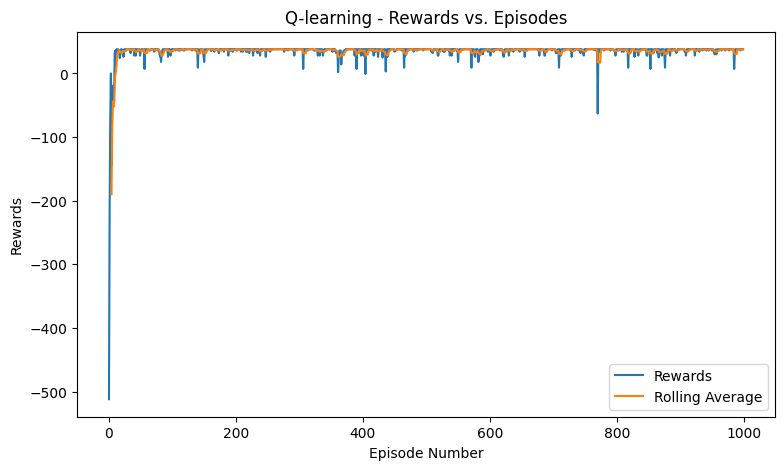

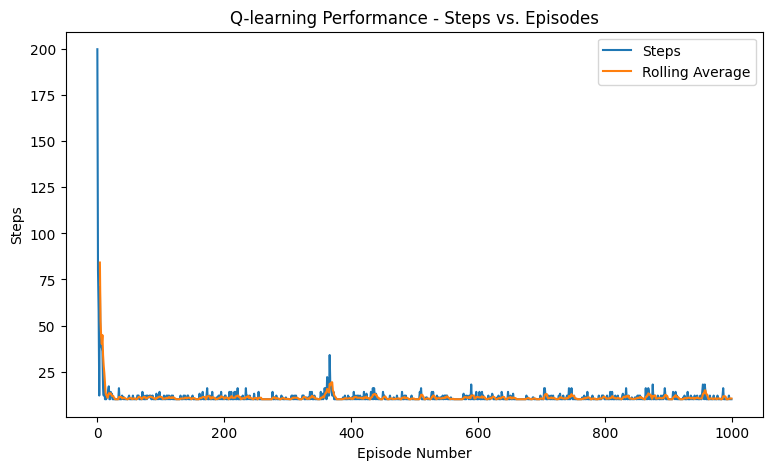

In [19]:
# Convert Rewards/episode to series
rewards_series=pd.Series(df_episode['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode['Num_steps'].values, name="Step")

######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series.plot(ax=ax, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=ax))
_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series.plot(ax=ax, label="Steps")
_ = (steps_series.rolling(window=5) .mean().rename("Rolling Average").plot(ax=ax))

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different Alpha values

In [20]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 5
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 5
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***e

In [21]:
# Hyperparameters of Q-learning
alpha=0.4
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: -1
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 5
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***

In [22]:
# Hyperparameters of Q-learning
alpha=0.7
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 5
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 5
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***e

In [23]:
# Hyperparameters of Q-learning
alpha=0.9
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 5
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 5
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***e

In [24]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

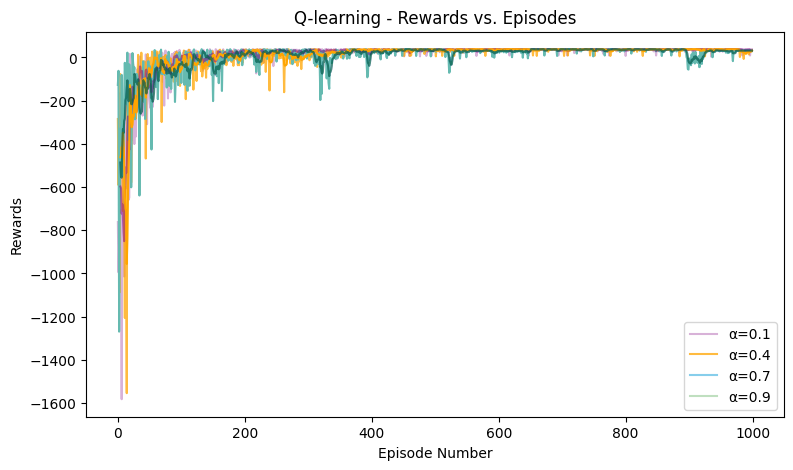

In [25]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = rewards_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")


In [26]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

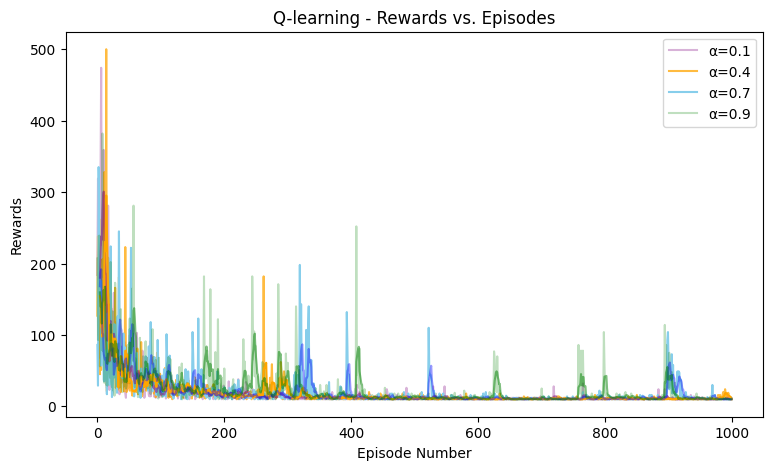

In [27]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = steps_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")


#### Test of different Gamma values

In [28]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.4
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)


--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 5
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 5
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 5
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 5
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***eps

In [29]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.8
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 5
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 5
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: -1
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 5
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***ep

In [30]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 5
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 5
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 5
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 5
***eps

In [31]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.99
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 5
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: -1
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 5
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 5
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 5
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 5
***epsi

In [32]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

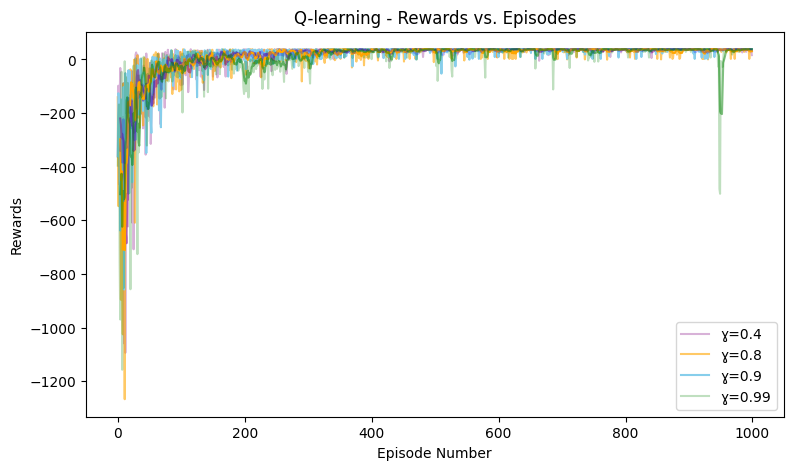

In [33]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, label="ɣ=0.4", color='purple', alpha=0.3)
_ = rewards_series2.plot(ax=ax,alpha=0.6, label="ɣ=0.8", color='orange')
_ = rewards_series3.plot(ax=ax,label="ɣ=0.9", color='skyblue')
_ = rewards_series4.plot(ax=ax, alpha =0.25, label="ɣ=0.99", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.25)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [34]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

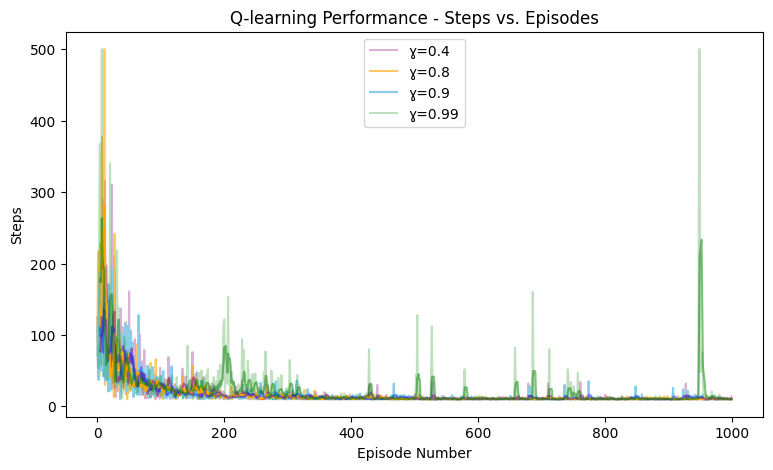

In [35]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ɣ=0.4", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax, label="ɣ=0.8", color='orange', alpha=0.6)
_ = steps_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, label="ɣ=0.99", alpha=0.25, color='green')



ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different epsilon decay values

In [36]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.900
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)


--- Episode 0 ---
--reward: 30
***epsilon: 0.9
--- Episode 1 ---
--reward: 30
***epsilon: 0.81
--- Episode 2 ---
--reward: 30
***epsilon: 0.7290000000000001
--- Episode 3 ---
--reward: 30
***epsilon: 0.6561000000000001
--- Episode 4 ---
--reward: 30
***epsilon: 0.5904900000000002
--- Episode 5 ---
--reward: 30
***epsilon: 0.5314410000000002
--- Episode 6 ---
--reward: 30
***epsilon: 0.47829690000000014
--- Episode 7 ---
--reward: 30
***epsilon: 0.43046721000000016
--- Episode 8 ---
--reward: 30
***epsilon: 0.38742048900000015
--- Episode 9 ---
--reward: 5
***epsilon: 0.34867844010000015
--- Episode 10 ---
--reward: 30
***epsilon: 0.31381059609000017
--- Episode 11 ---
--reward: 5
***epsilon: 0.28242953648100017
--- Episode 12 ---
--reward: 30
***epsilon: 0.25418658283290013
--- Episode 13 ---
--reward: 30
***epsilon: 0.22876792454961012
--- Episode 14 ---
--reward: 5
***epsilon: 0.2058911320946491
--- Episode 15 ---
--reward: 30
***epsilon: 0.1853020188851842
--- Episode 16 ---
--rewar

In [37]:
# Hyperparameters of Q-learning
alpha=0.3
gamma=0.9
epsilon = 1.0
epsilon_decay=0.990
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.99
--- Episode 1 ---
--reward: 30
***epsilon: 0.9801
--- Episode 2 ---
--reward: 30
***epsilon: 0.9702989999999999
--- Episode 3 ---
--reward: 5
***epsilon: 0.96059601
--- Episode 4 ---
--reward: 5
***epsilon: 0.9509900498999999
--- Episode 5 ---
--reward: 5
***epsilon: 0.9414801494009999
--- Episode 6 ---
--reward: 30
***epsilon: 0.9320653479069899
--- Episode 7 ---
--reward: 30
***epsilon: 0.92274469442792
--- Episode 8 ---
--reward: 30
***epsilon: 0.9135172474836407
--- Episode 9 ---
--reward: 30
***epsilon: 0.9043820750088043
--- Episode 10 ---
--reward: 30
***epsilon: 0.8953382542587163
--- Episode 11 ---
--reward: 5
***epsilon: 0.8863848717161291
--- Episode 12 ---
--reward: 5
***epsilon: 0.8775210229989678
--- Episode 13 ---
--reward: 30
***epsilon: 0.8687458127689781
--- Episode 14 ---
--reward: 30
***epsilon: 0.8600583546412883
--- Episode 15 ---
--reward: 30
***epsilon: 0.8514577710948754
--- Episode 16 ---
--reward: 30
***epsilon:

In [38]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.999
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.999
--- Episode 1 ---
--reward: 30
***epsilon: 0.998001
--- Episode 2 ---
--reward: 30
***epsilon: 0.997002999
--- Episode 3 ---
--reward: 5
***epsilon: 0.996005996001
--- Episode 4 ---
--reward: 30
***epsilon: 0.995009990004999
--- Episode 5 ---
--reward: 5
***epsilon: 0.994014980014994
--- Episode 6 ---
--reward: 30
***epsilon: 0.993020965034979
--- Episode 7 ---
--reward: 30
***epsilon: 0.9920279440699441
--- Episode 8 ---
--reward: 5
***epsilon: 0.9910359161258742
--- Episode 9 ---
--reward: 30
***epsilon: 0.9900448802097482
--- Episode 10 ---
--reward: 30
***epsilon: 0.9890548353295385
--- Episode 11 ---
--reward: 30
***epsilon: 0.988065780494209
--- Episode 12 ---
--reward: 30
***epsilon: 0.9870777147137147
--- Episode 13 ---
--reward: 30
***epsilon: 0.986090636999001
--- Episode 14 ---
--reward: 30
***epsilon: 0.9851045463620021
--- Episode 15 ---
--reward: 30
***epsilon: 0.98411944181564
--- Episode 16 ---
--reward: 30
***epsilon: 0.

In [39]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.9999
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.9999
--- Episode 1 ---
--reward: 30
***epsilon: 0.9998000100000001
--- Episode 2 ---
--reward: 30
***epsilon: 0.9997000299990001
--- Episode 3 ---
--reward: 30
***epsilon: 0.9996000599960002
--- Episode 4 ---
--reward: 30
***epsilon: 0.9995000999900007
--- Episode 5 ---
--reward: 30
***epsilon: 0.9994001499800017
--- Episode 6 ---
--reward: 5
***epsilon: 0.9993002099650037
--- Episode 7 ---
--reward: 30
***epsilon: 0.9992002799440072
--- Episode 8 ---
--reward: 30
***epsilon: 0.9991003599160128
--- Episode 9 ---
--reward: 30
***epsilon: 0.9990004498800211
--- Episode 10 ---
--reward: 30
***epsilon: 0.9989005498350332
--- Episode 11 ---
--reward: 5
***epsilon: 0.9988006597800497
--- Episode 12 ---
--reward: 5
***epsilon: 0.9987007797140718
--- Episode 13 ---
--reward: 30
***epsilon: 0.9986009096361004
--- Episode 14 ---
--reward: 30
***epsilon: 0.9985010495451367
--- Episode 15 ---
--reward: 30
***epsilon: 0.9984011994401822
--- Episode 16 --

In [40]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

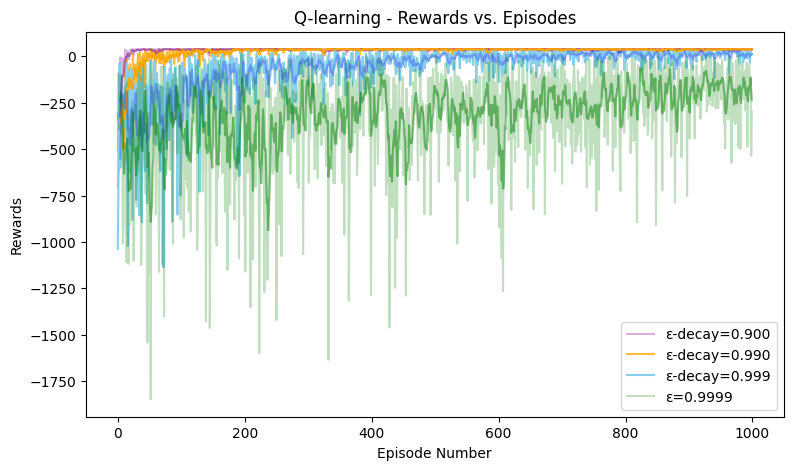

In [41]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="ε-decay=0.900",  color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ε-decay=0.990", color='orange')
_ = rewards_series3.plot(ax=ax, label="ε-decay=0.999", color='skyblue')
_ = rewards_series4.plot(ax=ax,label="ε=0.9999", color='green', alpha=0.25)

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.25)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [42]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

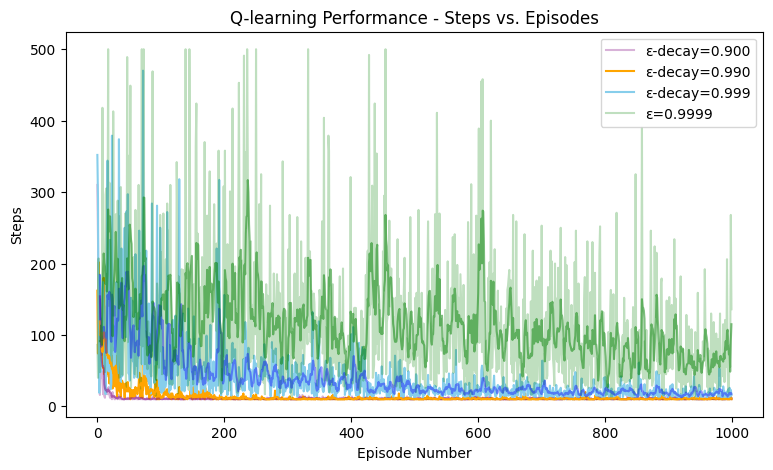

In [43]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ε-decay=0.900", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax, label="ε-decay=0.990",  color='orange')
_ = steps_series3.plot(ax=ax, label="ε-decay=0.999",  color='skyblue')
_ = steps_series4.plot(ax=ax,label="ε=0.9999", color='green', alpha =0.25)

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different epsilons values

In [44]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.1
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.0995
--- Episode 1 ---
--reward: 30
***epsilon: 0.09900250000000001
--- Episode 2 ---
--reward: 30
***epsilon: 0.0985074875
--- Episode 3 ---
--reward: 5
***epsilon: 0.09801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.09752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.09703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.09655206468094843
--- Episode 7 ---
--reward: 30
***epsilon: 0.09606930435754368
--- Episode 8 ---
--reward: 30
***epsilon: 0.09558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.09511101304657718
--- Episode 10 ---
--reward: 30
***epsilon: 0.09463545798134429
--- Episode 11 ---
--reward: 30
***epsilon: 0.09416228069143756
--- Episode 12 ---
--reward: 30
***epsilon: 0.09369146928798038
--- Episode 13 ---
--reward: 30
***epsilon: 0.09322301194154048
--- Episode 14 ---
--reward: 30
***epsilon: 0.09275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.09229311239742362
--- Epi

In [45]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.5
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.4975
--- Episode 1 ---
--reward: 30
***epsilon: 0.4950125
--- Episode 2 ---
--reward: 30
***epsilon: 0.4925374375
--- Episode 3 ---
--reward: 30
***epsilon: 0.49007475031250003
--- Episode 4 ---
--reward: 30
***epsilon: 0.48762437656093754
--- Episode 5 ---
--reward: 30
***epsilon: 0.48518625467813287
--- Episode 6 ---
--reward: 30
***epsilon: 0.4827603234047422
--- Episode 7 ---
--reward: 30
***epsilon: 0.4803465217877185
--- Episode 8 ---
--reward: 30
***epsilon: 0.47794478917877986
--- Episode 9 ---
--reward: 30
***epsilon: 0.47555506523288593
--- Episode 10 ---
--reward: 30
***epsilon: 0.4731772899067215
--- Episode 11 ---
--reward: 30
***epsilon: 0.47081140345718786
--- Episode 12 ---
--reward: 30
***epsilon: 0.46845734643990194
--- Episode 13 ---
--reward: 30
***epsilon: 0.46611505970770245
--- Episode 14 ---
--reward: 30
***epsilon: 0.4637844844091639
--- Episode 15 ---
--reward: 30
***epsilon: 0.4614655619871181
--- Episode 16 ---
--

In [46]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.9
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.8955
--- Episode 1 ---
--reward: 30
***epsilon: 0.8910224999999999
--- Episode 2 ---
--reward: 30
***epsilon: 0.8865673875
--- Episode 3 ---
--reward: 30
***epsilon: 0.8821345505625
--- Episode 4 ---
--reward: 30
***epsilon: 0.8777238778096875
--- Episode 5 ---
--reward: 30
***epsilon: 0.8733352584206391
--- Episode 6 ---
--reward: 30
***epsilon: 0.8689685821285359
--- Episode 7 ---
--reward: 5
***epsilon: 0.8646237392178933
--- Episode 8 ---
--reward: 30
***epsilon: 0.8603006205218038
--- Episode 9 ---
--reward: 30
***epsilon: 0.8559991174191948
--- Episode 10 ---
--reward: 30
***epsilon: 0.8517191218320987
--- Episode 11 ---
--reward: 30
***epsilon: 0.8474605262229382
--- Episode 12 ---
--reward: 30
***epsilon: 0.8432232235918236
--- Episode 13 ---
--reward: 30
***epsilon: 0.8390071074738644
--- Episode 14 ---
--reward: 30
***epsilon: 0.8348120719364951
--- Episode 15 ---
--reward: 30
***epsilon: 0.8306380115768126
--- Episode 16 ---
--rew

In [47]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 5
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***

In [48]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

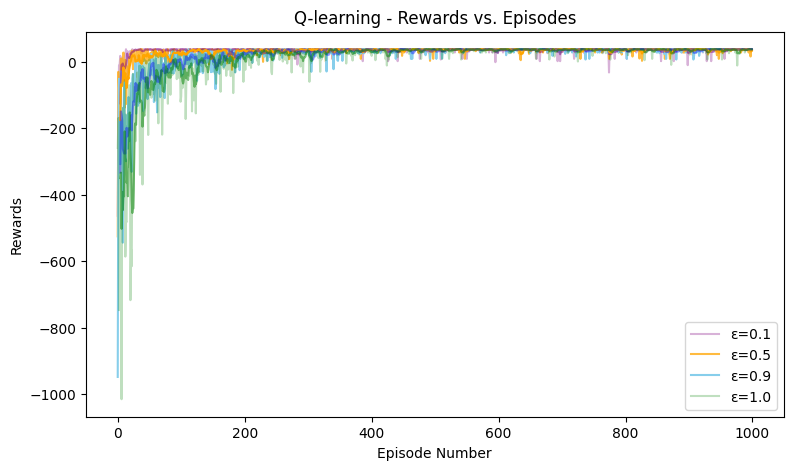

In [49]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, label="ε=0.1", color='purple', alpha=0.3)
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ε=0.5", color='orange')
_ = rewards_series3.plot(ax=ax, label="ε=0.9", color='skyblue')
_ = rewards_series4.plot(ax=ax, alpha =0.25, label="ε=1.0", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [50]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

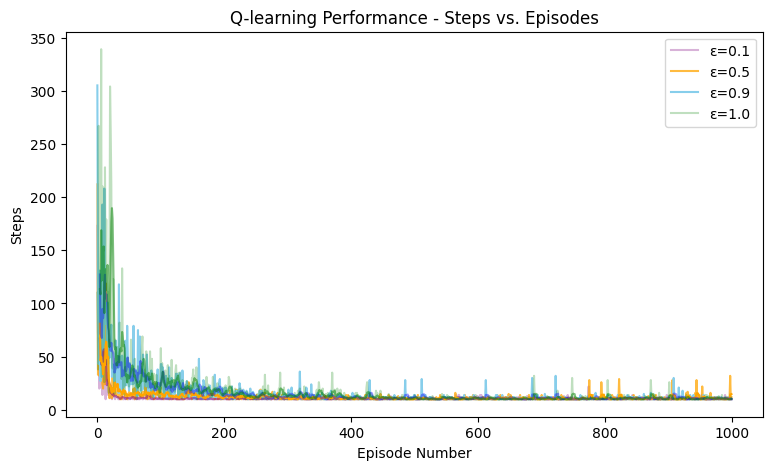

In [51]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ε=0.1", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax,alpha=0.75, label="ε=0.5", color='orange')
_ = steps_series3.plot(ax=ax, label="ε=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha =0.25, label="ε=1.0", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

## 2. Experiment with Softmax policy

#### Q-learning and softmax policy

In [52]:
def softmax(q_table, state_index, temperature):
    q_value = q_table[state_index]
    q_value = np.array(q_value)
    max_q = np.max(q_value)
    exp_q = np.exp((q_value - max_q) / temperature)
    probability = exp_q / np.sum(exp_q)
    action = np.random.choice(len(q_value), p=probability)
    return action

In [57]:
# Q-learning with Softmax policy

def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning function
def q_learning(env, alpha, gamma, temperature, min_temperature, temperature_decay, episodes,max_steps):

    # Initialize Q-table with shape (36, 4) = (state, action)
    q_table = np.zeros((env.gridsize[0] * env.gridsize[1], env.action_space.n))

    # Vi
    # Create a df to store episode and number of steps
    df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])
    total_reward = 0

    for episode in range(episodes):
        state = env.reset()
        # Convert state to index
        state_index = state_to_index(state, env.gridsize[1])
        done = False
        # Vi
        num_step = 0
        reward_per_episode = 0
        print("--- Episode",episode,"---")

        while not done and num_step <max_steps:

            # Choose action based on sotfmax policy
            action = softmax(q_table, state_index, temperature)
            # Take the action and observe the result
            next_state, reward, done = env.step(action)

            # Convert next state to index
            next_state_index = state_to_index(next_state, env.gridsize[1])

            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            # Move to the next state
            state = next_state
            # Update the state index
            state_index = next_state_index
            #env.render_2()

            # Add up reward
            total_reward +=reward

            # Track number of steps
            num_step = num_step+1
            # Track reward per episode
            print("--reward:", reward)
            reward_per_episode += reward

        # Update temperature
        # Decay temperature to reduce exploration over time
        temperature = max(min_temperature, temperature * np.exp(-temperature_decay * episode))

        new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
        df_epsisode.loc[len(df_epsisode)] = new_track



    return q_table, total_reward, df_epsisode


#### Run Q-learning

In [58]:
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.7
gamma=0.9
episodes=1000
total_reward = 0
max_steps=300

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    q_table, total_reward, df_episode_soft = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print()
    print(episodes)
    print(q_table)

Streaming output truncated to the last 5000 lines.
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: -1
--reward:

In [ ]:
#df_episode_soft['Reward'][150:200]

In [ ]:
#df_episode_soft['Num_steps'][150:200]

In [59]:
rewards_series=pd.Series(df_episode_soft['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode_soft['Num_steps'].values, name="Step")

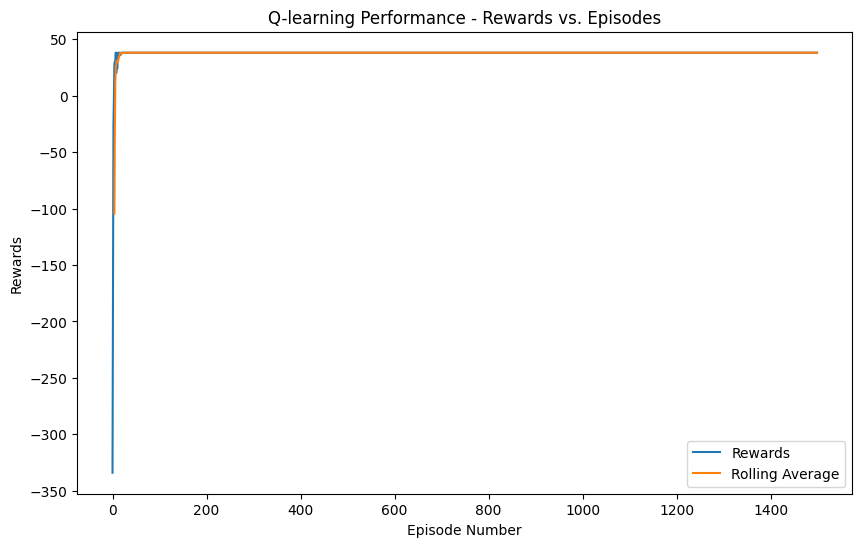

In [99]:
#### Plot of Rewards vs. Episodes
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Rewards vs. Episodes")

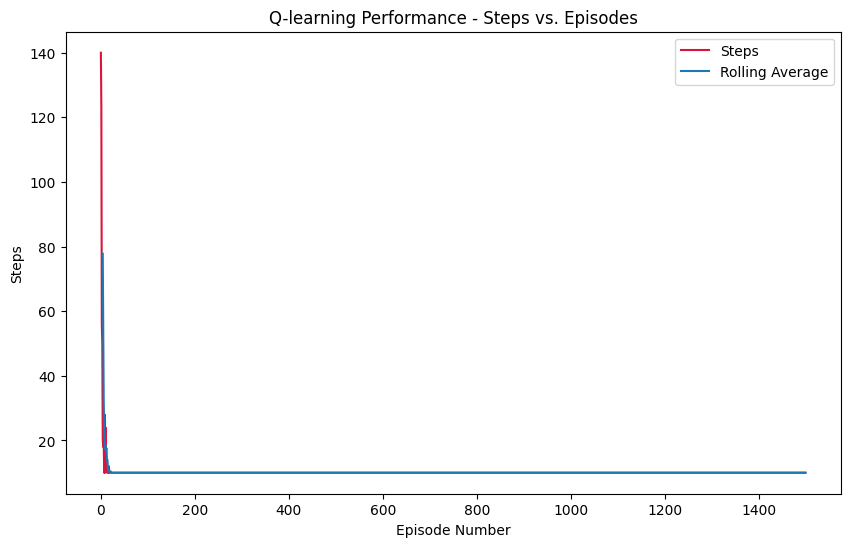

In [100]:
#### Plot of Steps vs. Episodes
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

#### Random Search: Best parameter

In [62]:
import random
min_temperature=0.01
max_steps=300

def random_search_q_learning(env, param_grid, num_samples=60):
    # Store the best parameters and performance
    best_params = None
    best_performance = float('-inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(num_samples):
        # Randomly sample values for each hyperparameter
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        temperature = random.choice(param_grid['temperature'])
        temperature_decay = random.choice(param_grid['temperature_decay'])
        episodes = random.choice(param_grid['episodes'])

        # Initialize total reward tracker
        total_reward = 0

        # Call Q-learning function with the current set of hyperparameters
        q_table, total_reward, df_episode = q_learning(env, alpha, gamma, temperature, temperature_decay, min_temperature,max_steps, episodes)

        average_rewards = np.mean(df_episode['Reward'].values[-500:])

        # Record the best performance
        if average_rewards > best_performance:
            best_performance = average_rewards
            best_params = {'alpha': alpha, 'gamma': gamma, 'temperature': temperature, 'temperature_decay': temperature_decay, 'episodes': episodes}

    return best_params, best_performance

# Define the hyperparameter grid (ranges for each hyperparameter)
param_grid = {
    'alpha': [0.1, 0.4, 0.7, 0.9],  # Learning rate
    'gamma': [0.4, 0.8, 0.9, 0.99],  # Discount factor
    'temperature': [0.1, 0.5, 1.0, 4.0],  # Initial temperature
    'temperature_decay': [0.1, 0.5, 0.7, 0.9],  # Decay factor for temperature
    'episodes': [500, 1000, 1500],  # Number of episodes to run
}


# Perform random search
best_params, best_performance = random_search_q_learning(env, param_grid, num_samples=60)

# Output the results
print(f"Best parameters: {best_params}")
print(f"Best performance: {best_performance}")

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -10
--reward: -1
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: -1
--reward: -1
--reward: 30
--- Episode 4 ---
--reward: -10
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -

In [63]:
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.9
alpha=0.4
gamma=0.99
episodes=1500
total_reward = 0
max_steps=300

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    q_table, total_reward, df_episode_soft = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay, episodes, max_steps)
    print()
    print(episodes)
    print(q_table)

Streaming output truncated to the last 5000 lines.
--reward: 30
--- Episode 1049 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1050 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1051 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1052 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1053 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1054 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 1055 ---
--reward: -1
--

In [64]:
rewards_series=pd.Series(df_episode_soft['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode_soft['Num_steps'].values, name="Step")

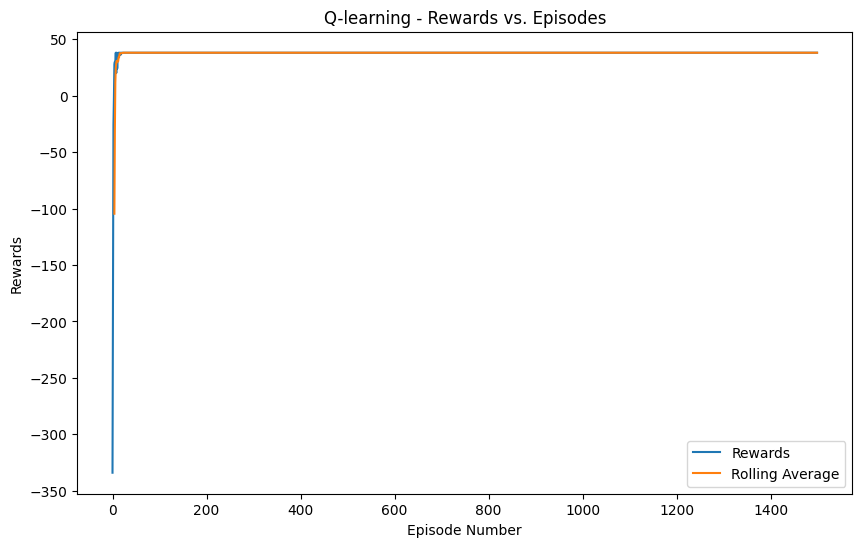

In [65]:
#### Plot of Rewards and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning - Rewards vs. Episodes")

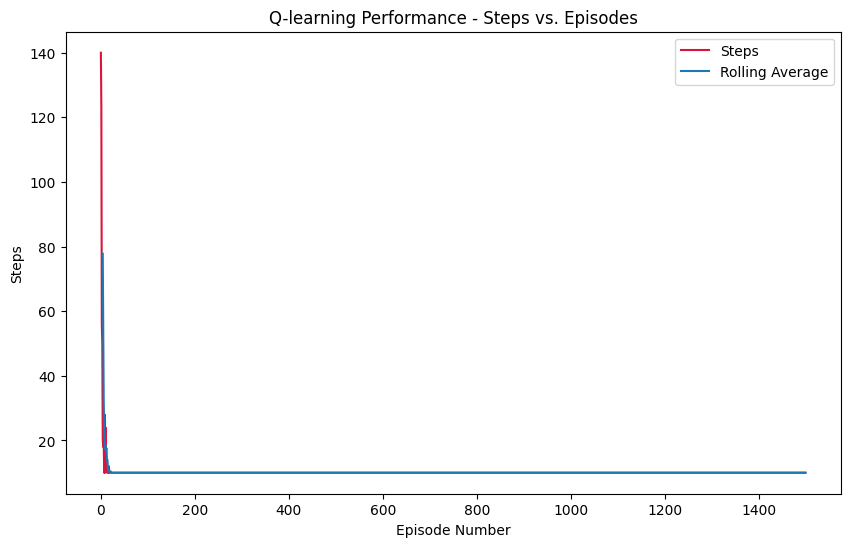

In [66]:
#### Plot of Steps and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different Alpha values

In [101]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.999
alpha=0.1
gamma=0.99
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: 

In [68]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.4
gamma=0.9
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 5
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 5
--- Episode 555 ---
--reward: -1
--re

In [69]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.7
gamma=0.9
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 555 ---
--r

In [70]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.9
gamma=0.9
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: 30
--- Episode 555 ---
--r

In [71]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

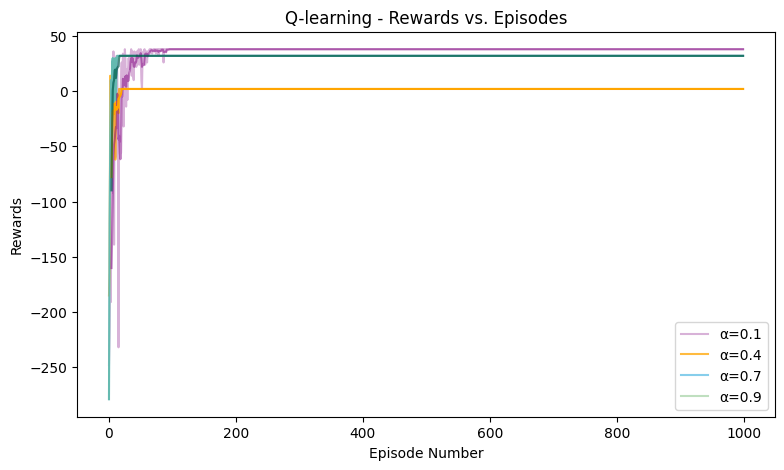

In [72]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = rewards_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [73]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

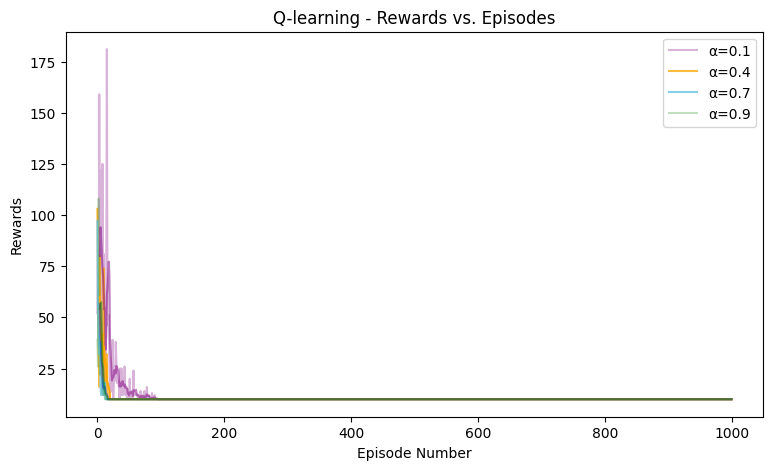

In [74]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = steps_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

#### Test of different Gamma values

In [75]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 556 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 557 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 558 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--r

In [76]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.1
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: 

In [77]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.1
gamma=0.9
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: 

In [78]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.1
gamma=0.99
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 30
--- Episode 549 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 550 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 551 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 552 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: 

In [79]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

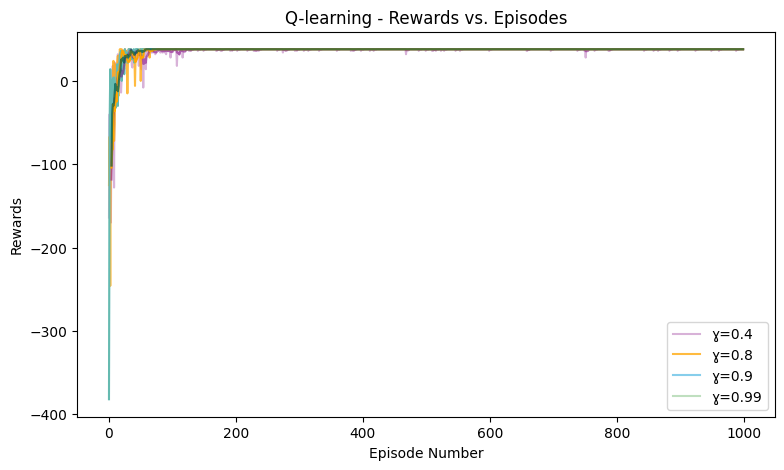

In [80]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="ɣ=0.4", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ɣ=0.8", color='orange')
_ = rewards_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="ɣ=0.99", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [81]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

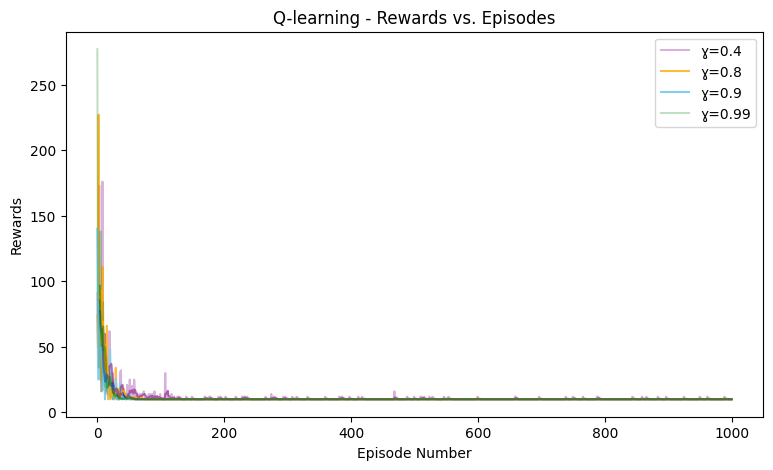

In [82]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="ɣ=0.4", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="ɣ=0.8", color='orange')
_ = steps_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="ɣ=0.99", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

#### Test of different temperature-decay rate

In [102]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.1
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 553 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 556 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 557 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 558 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--r

In [84]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.9
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 725 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 726 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 727 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 728 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 729 

In [85]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.999
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 30
--- Episode 739 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 740 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 741 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 742 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 743 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward

In [86]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.9999
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 729 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 730 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 731 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 732 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 733 ---
--reward: -1
--reward: -1
--reward: -1
--reward:

In [103]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

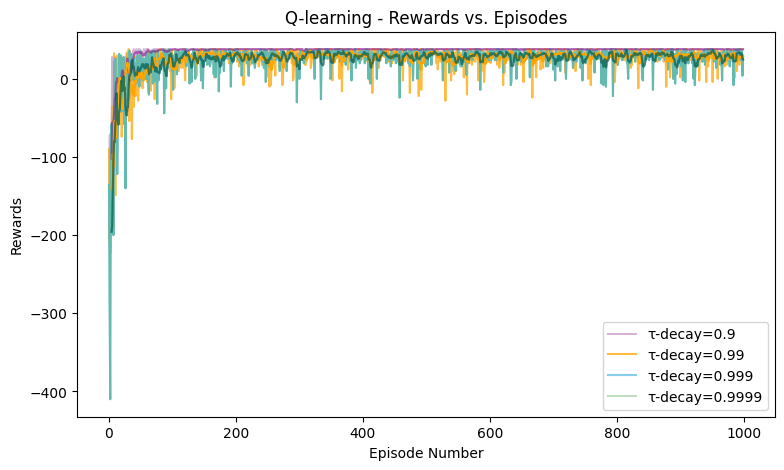

In [104]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="τ-decay=0.9", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="τ-decay=0.99", color='orange')
_ = rewards_series3.plot(ax=ax, label="τ-decay=0.999", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="τ-decay=0.9999", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [105]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

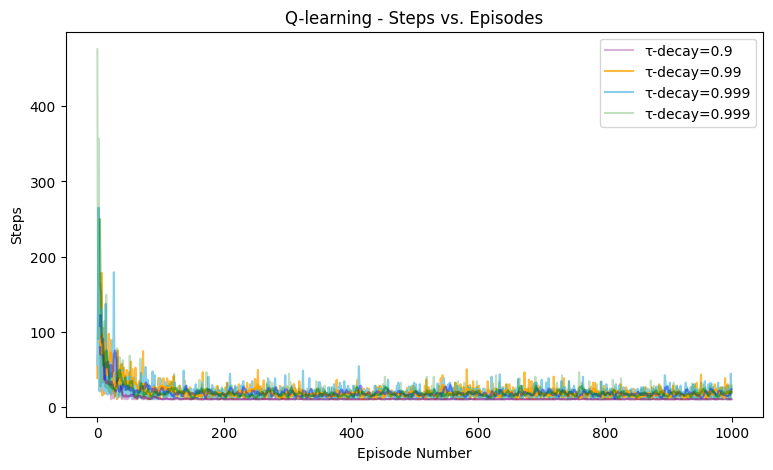

In [106]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="τ-decay=0.9", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="τ-decay=0.99", color='orange')
_ = steps_series3.plot(ax=ax, label="τ-decay=0.999", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="τ-decay=0.999", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

#### Test of different temperature values

In [91]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.100
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 554 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 555 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 556 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 557 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 558 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 559 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--r

In [92]:
# Hyperparameters of Q-learning
temperature = 0.4
min_temperature = 0.01
temperature_decay = 0.995
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, temperature_decay, min_temperature, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 721 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 722 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 723 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 724 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--r

In [93]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.01
temperature_decay = 0.995
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 731 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 732 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 733 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--rewar

In [94]:
# Hyperparameters of Q-learning
temperature = 4.0
min_temperature = 0.01
temperature_decay = 0.995
alpha=0.1
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

Streaming output truncated to the last 5000 lines.
--reward: 5
--reward: 30
--- Episode 732 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 733 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: 5
--reward: 30
--- Episode 734 ---
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: 10
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward: -1
--reward

In [95]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

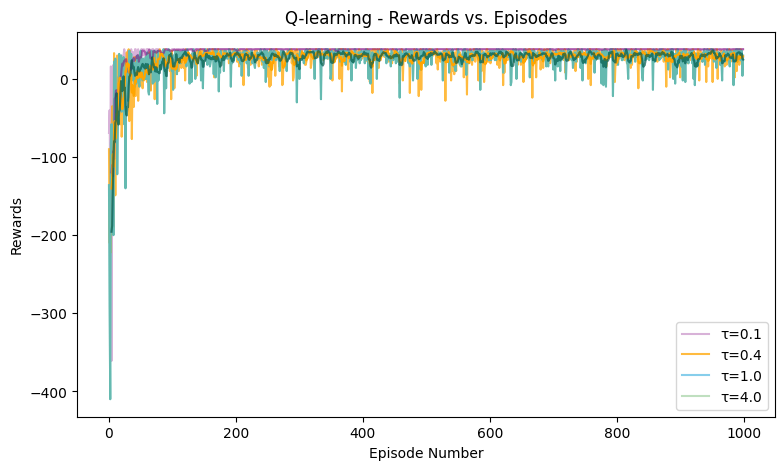

In [96]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="τ=0.1", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="τ=0.4", color='orange')
_ = rewards_series3.plot(ax=ax, label="τ=1.0", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="τ=4.0", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [97]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

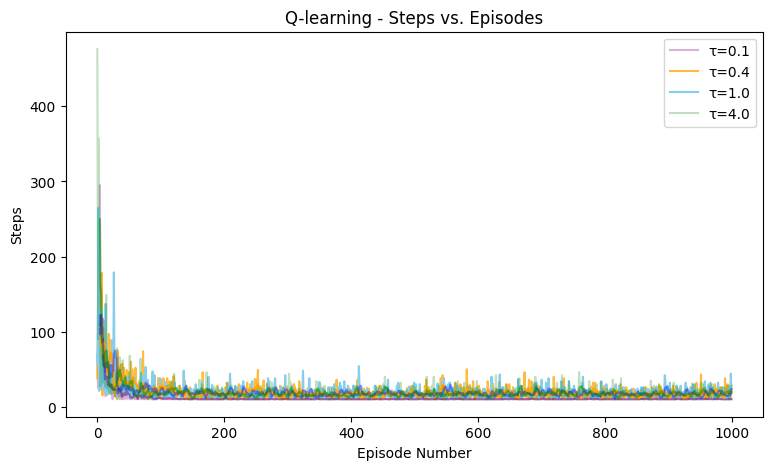

In [98]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="τ=0.1", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="τ=0.4", color='orange')
_ = steps_series3.plot(ax=ax, label="τ=1.0", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="τ=4.0", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

## Pygame

In [ ]:
#pip install pygame

In [ ]:
# import pygame
# import sys

# # --- Settings ---
# GRID_SIZE = 6
# CELL_SIZE = 80
# WIDTH, HEIGHT = GRID_SIZE * CELL_SIZE, GRID_SIZE * CELL_SIZE
# FPS = 60

# # Colors
# WHITE = (255, 255, 255)
# GRAY = (200, 200, 200)

# # Initialize pygame
# pygame.init()
# screen = pygame.display.set_mode((WIDTH, HEIGHT))
# pygame.display.set_caption("Mario GridWorld")
# clock = pygame.time.Clock()

# # Load Mario icon
# mario_img = pygame.image.load("mario.png")
# mario_img = pygame.transform.scale(mario_img, (CELL_SIZE, CELL_SIZE))

# # Agent's initial position
# agent_pos = [0, 0]  # [row, col]

# def draw_grid():
#     for x in range(0, WIDTH, CELL_SIZE):
#         for y in range(0, HEIGHT, CELL_SIZE):
#             rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)
#             pygame.draw.rect(screen, GRAY, rect, 1)

# def draw_agent():
#     row, col = agent_pos
#     x = col * CELL_SIZE
#     y = row * CELL_SIZE
#     screen.blit(mario_img, (x, y))

# # --- Game loop ---
# running = True
# while running:
#     clock.tick(FPS)
#     screen.fill(WHITE)

#     # Handle events
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             running = False

#         elif event.type == pygame.KEYDOWN:
#             if event.key == pygame.K_UP and agent_pos[0] > 0:
#                 agent_pos[0] -= 1
#             elif event.key == pygame.K_DOWN and agent_pos[0] < GRID_SIZE - 1:
#                 agent_pos[0] += 1
#             elif event.key == pygame.K_LEFT and agent_pos[1] > 0:
#                 agent_pos[1] -= 1
#             elif event.key == pygame.K_RIGHT and agent_pos[1] < GRID_SIZE - 1:
#                 agent_pos[1] += 1

#     # Draw
#     draw_grid()
#     draw_agent()
#     pygame.display.flip()

# pygame.quit()
# sys.exit()


#### Graph mean + std

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate mock data: 10 runs, 200 episodes
np.random.seed(42)
num_runs = 10
num_episodes = 200

# Simulate learning curves with noise
true_curve = np.linspace(-200, -110, num_episodes)  # improving reward
rewards_matrix = np.array([
    true_curve + np.random.normal(0, 10, size=num_episodes) for _ in range(num_runs)
])

# Calculate mean and std
mean_rewards = np.mean(rewards_matrix, axis=0)
std_rewards = np.std(rewards_matrix, axis=0)
episodes = np.arange(num_episodes)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_rewards, label='Mean Reward', color='blue')
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards,
                 alpha=0.3, color='blue', label='±1 Std Dev')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Double DQN on MountainCar-v0\n(Mean ± Std Dev


## Optuna test

In [ ]:
#pip install optuna
# import optuna
# from optuna.trial import TrialState

# # Optuna objective function
# def objective(trial):
#   # Hyperparameters to tune
#   alpha = trial.suggest_int('alpha', 0.01, 0.9)
#   gamma = trial.suggest_int('gamma', 0.8, 0.99)
#   epsilon = trial.suggest_int('epsilon', 0.4, 1.0)
#   epsilon_decay = trial.suggest_int('epsilon_decay', 0.8, 0.9999)

#   # Initialize total reward tracker
#   total_reward = 0

#   # Call Q-learning function with the current set of hyperparameters
#   q_table, total_reward, df_episode = q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30, n_jobs=-1)
# q_trials = study.trials_dataframe()
# q_trials.head()
# print("Best Hyperparameters:", study.best_params)